Suggested Bin width: 0.00608364310378425
Suggested Number of bins: 14
Optimal Weibull parameters: shape (c) = 3.849, scale = 0.027, R² = 0.787


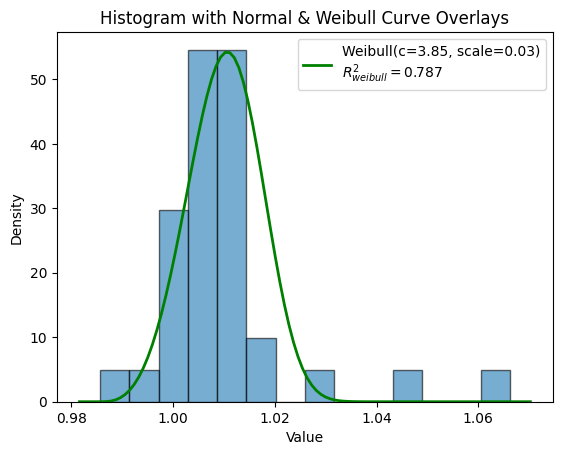


Expected value (Weibull): 1.0101
99% Confidence error from expected value: 0.0033 or 0.32% of the Expected Value


In [92]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import weibull_min, t
import scipy.special as sps  # for the gamma function

# 14500 RPM Head
# Sample data - replace this list with your actual data
# remove outlier ,1.0662,1.0469
data = [1.0152, 0.9952, 1.0002, 1.0094, 1.0084, 1.0018, 1.0101, 1.0142,
        1.0130, 0.9993, 1.0031, 1.0090, 1.0046, 1.0086, 1.0129, 1.0078,
        1.0034, 1.0283, 1.0114, 1.0029, 1.0201, 1.0135, 0.9999, 1.0033,
        1.0082, 0.9856, 0.9995, 1.0011, 1.0074, 1.0121, 1.0101, 1.0136,
        1.0070, 1.0662, 1.0469]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Normal & Weibull Curve Overlays")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"99% Confidence error from expected value: {t_crit * std_error_weibull:.4f} "
      f"or {t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")

Suggested Bin width: 0.004310520993133607
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 2.121, scale = 0.013, R² = 0.948


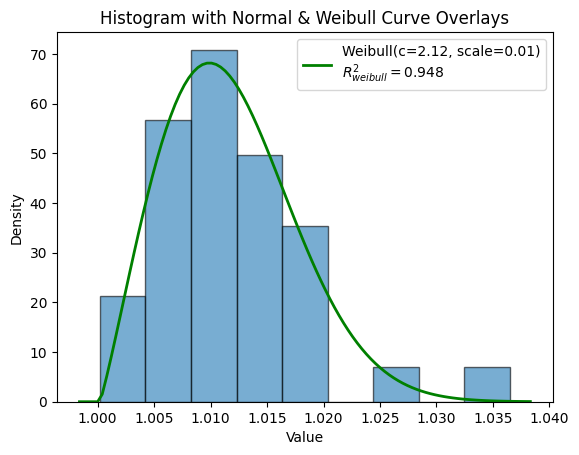


Expected value (Weibull): 1.0118
99% Confidence error from expected value: 0.0027 or 0.26% of the Expected Value


In [93]:
# 14500 RPM Power
# Sample data - replace this list with your actual data
data = [1.0153,1.0090,1.0109,1.0365,1.0094,1.0073,1.0064,1.0120,1.0132,1.0155,1.0052,1.0062,1.0125,1.0082,1.0132,1.0164,1.0106,1.0072,1.0201,1.0131,1.0254,1.0110,1.0175,1.0164,1.0042,1.0108,1.0143,1.0002,1.0075,1.0028,1.0095,1.0104,1.0099,1.0167,1.0080]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Normal & Weibull Curve Overlays")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"99% Confidence error from expected value: {t_crit * std_error_weibull:.4f} "
      f"or {t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")

Suggested Bin width: 0.009538174112465752
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 1.460, scale = 0.022, R² = 0.846


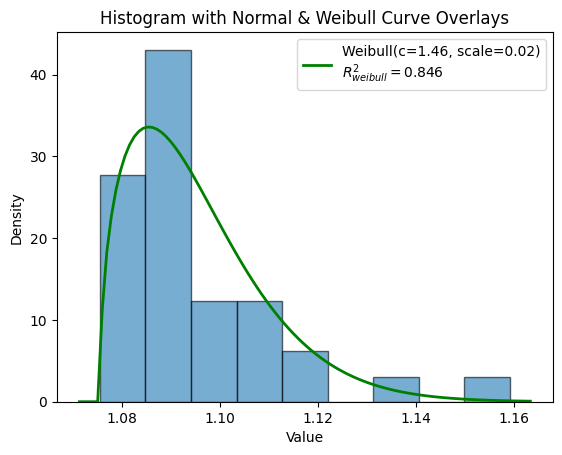


Expected value (Weibull): 1.0956
99% Confidence error from expected value: 0.0064 or 0.58% of the Expected Value


In [94]:
# 15000 RPM Head
# Sample data - replace this list with your actual data
data = [1.0823,1.0889,1.1112,1.1592,1.0790,1.0963,1.0902,1.1127,1.0931,1.0859,1.0914,1.0994,1.1166,1.0910,1.0878,1.0847,1.0831,1.1357,1.0836,1.0833,1.1024,1.1070,1.1150,1.0900,1.0903,1.0902,1.0783,1.0927,1.1061,1.0809,1.0869,1.0756,1.0976,1.0867,1.0893]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Normal & Weibull Curve Overlays")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"99% Confidence error from expected value: {t_crit * std_error_weibull:.4f} "
      f"or {t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")



Suggested Bin width: 0.004707944914486374
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 2.301, scale = 0.015, R² = 0.806


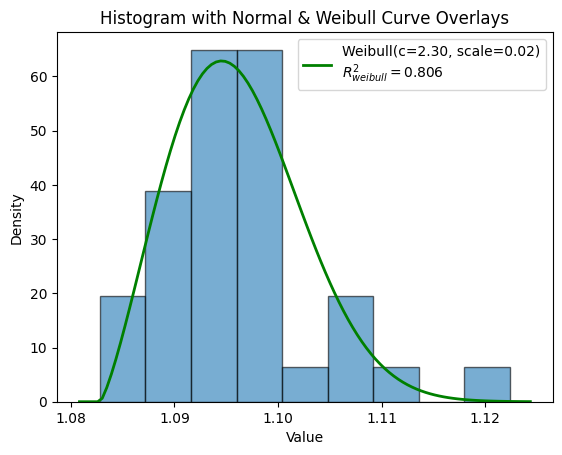


Expected value (Weibull): 1.0961
99% Confidence error from expected value: 0.0028 or 0.26% of the Expected Value


In [95]:
# 15000 RPM Power
# Sample data - replace this list with your actual data
data = [1.0893,1.0973,1.0993,1.1224,1.0828,1.0951,1.0991,1.0997,1.0967,1.0916,1.0964,1.0959,1.1029,1.0883,1.0955,1.0950,1.0861,1.1062,1.0935,1.0935,1.0980,1.1054,1.1102,1.0923,1.0918,1.0902,1.0886,1.0933,1.1080,1.0867,1.0907,1.0914,1.0996,1.0962,1.0960]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Normal & Weibull Curve Overlays")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"99% Confidence error from expected value: {t_crit * std_error_weibull:.4f} "
      f"or {t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")

Suggested Bin width: 0.012918214455045929
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 1.509, scale = 0.036, R² = 0.835


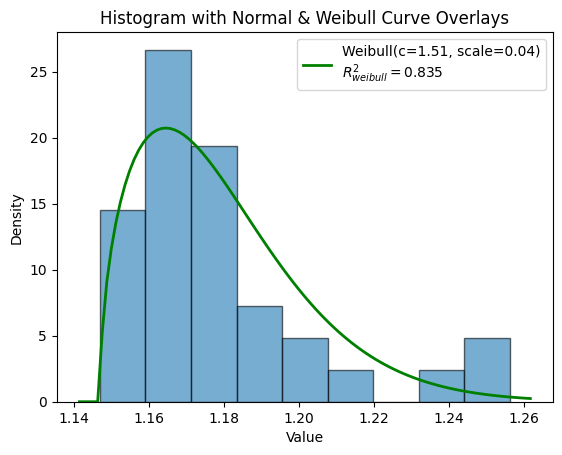


Expected value (Weibull): 1.1795
99% Confidence error from expected value: 0.0103 or 0.87% of the Expected Value


In [96]:
# 15500 RPM Head
# Sample data - replace this list with your actual data
data = [1.1800,1.2562,1.1894,1.1582,1.1633,1.2504,1.1723,1.2180,1.1820,1.1534,1.1606,1.1649,1.1608,1.1576,1.1971,1.1704,1.1652,1.1737,1.2356,1.1814,1.1794,1.1631,1.1828,1.1680,1.1470,1.1645,1.1949,1.1570,1.1845,1.1687,1.1764,1.1539,1.2027,1.1690]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Normal & Weibull Curve Overlays")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"99% Confidence error from expected value: {t_crit * std_error_weibull:.4f} "
      f"or {t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")

Suggested Bin width: 0.008766482449780231
Suggested Number of bins: 6
Optimal Weibull parameters: shape (c) = 1.383, scale = 0.017, R² = 0.911


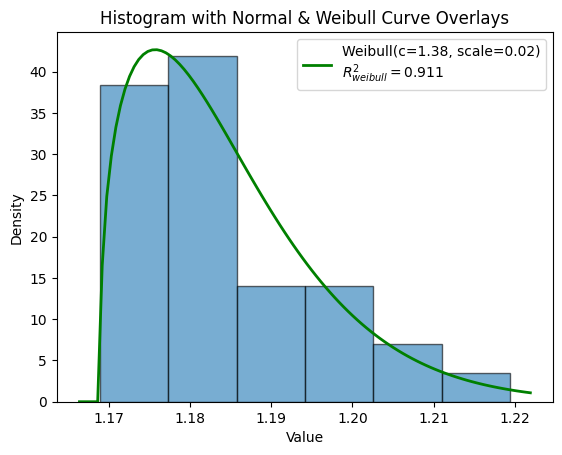


Expected value (Weibull): 1.1846
99% Confidence error from expected value: 0.0054 or 0.46% of the Expected Value


In [97]:
# 15500 RPM Power
# Sample data - replace this list with your actual data
data = [1.1780,1.2194,1.1927,1.1731,1.1805,1.2080,1.1801,1.2095,1.1833,1.1736,1.1819,1.1802,1.1689,1.1772,1.1968,1.1795,1.1728,1.1865,1.1967,1.1767,1.1872,1.1821,1.1772,1.1828,1.1729,1.1809,1.1970,1.1759,1.1931,1.1847,1.1771,1.1792,1.1947,1.1770]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.01
c_high = 2
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Normal & Weibull Curve Overlays")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# Display the results.
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"99% Confidence error from expected value: {t_crit * std_error_weibull:.4f} "
      f"or {t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")